# Market-implied price surfaces: v2

We improve on the previous analysis by porting the entire calculation to python, and using earnings recouped rather than FY2-5 growth

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use("seaborn-deep")
plt.rcParams["figure.figsize"] = (15, 10)


In [7]:
# INPUTS
base_year_earnings = 163
base_cash_return = 0.855
FY20_earnings_drop = -0.3
subseq_growth = 0.08
risk_free_rate = 0.0134
equity_risk_premium = 0.0525
long_term_growth_rate = 0.0134
long_term_roe = 0.15


# fraction_recouped = 

In [8]:
# Calculated parameters
discount_factor = 1/ (1 + risk_free_rate + equity_risk_premium) 

In [9]:
FY20_earnings_drop = -0.4
subseq_growth = 0.1

In [10]:
%%timeit
# Valuation
long_term_cash_return = 1 - long_term_growth_rate / long_term_roe

# Earnings
earnings = [base_year_earnings * (1 + FY20_earnings_drop)]
for _ in range(2, 6):
    earnings.append(earnings[-1] * (1+subseq_growth))

# Return fractions
return_fractions = []
for i in range(1, 6):
    return_fractions.append(base_cash_return + i * (long_term_cash_return - base_cash_return)/5)

# Cash flows
cash_flows = []
for i in range(5):
    cash_flows.append(earnings[i] * return_fractions[i])

pv_cash_flows = 0
for i in range(5):
    pv_cash_flows+= cash_flows[i] * discount_factor ** (i+1)
    
    
terminal_value = (cash_flows[-1] * (1 + long_term_growth_rate) / 
                  (risk_free_rate + equity_risk_premium - long_term_growth_rate))
pv_terminal = terminal_value * discount_factor ** 5

sp_value = pv_cash_flows + pv_terminal
sp_value


6.27 µs ± 99.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [5]:
def valuation(
    drop, growth,
    base_year_earnings = 163,
    base_cash_return = 0.855,
    risk_free_rate = 0.0134,
    equity_risk_premium = 0.0525,
    long_term_growth_rate = 0.0134,
    long_term_roe = 0.15
):
    long_term_cash_return = 1 - long_term_growth_rate / long_term_roe
    discount_factor = 1/ (1 + risk_free_rate + equity_risk_premium) 
    
    pv = 0
    earnings = base_year_earnings
    for i in range(1, 6):
        if i == 1:
            earnings *= (1 + drop)
        else:
            earnings *= (1 + growth)

        ret_frac = base_cash_return + i * (long_term_cash_return - base_cash_return)/5

        cash_flow = earnings * ret_frac
        pv += cash_flow * discount_factor ** i
    terminal_value = (earnings * (1 + long_term_growth_rate) * long_term_cash_return/ 
                      (risk_free_rate + equity_risk_premium - long_term_growth_rate))
    pv_terminal = terminal_value * discount_factor ** 5

    return pv + pv_terminal


In [6]:
%%timeit
valuation(-0.4, 0.12)

3.05 µs ± 73.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Rebuilding the plot




In [115]:
n_res = 100
growth = np.linspace(-0.05, 0.25, n_res)
drop = np.linspace(-0.5, 0, n_res)

X, Y = np.meshgrid(growth, drop)
Z = np.zeros((n_res, n_res))
for i, x in enumerate(growth):
    for j, y in enumerate(drop):
        Z[i, j] = valuation(y, x)


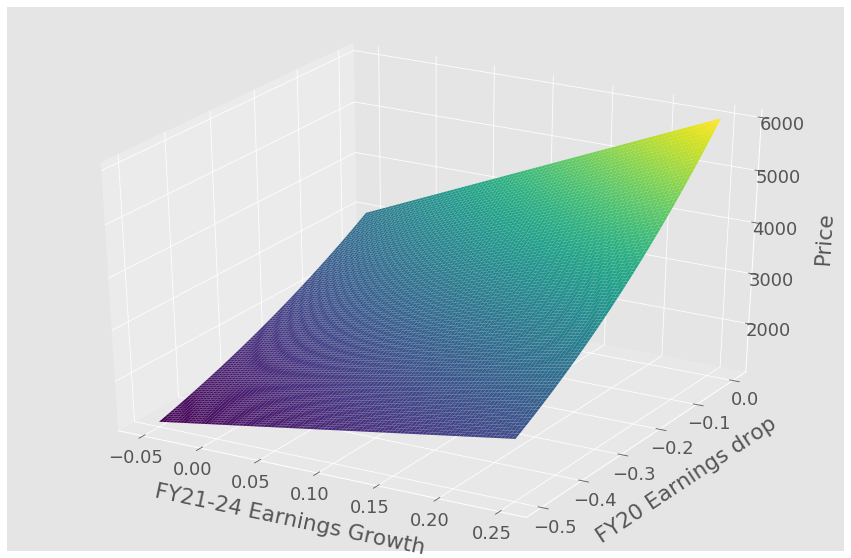

In [116]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');
ax.set_xlabel("FY21-24 Earnings Growth", labelpad=20)
ax.set_ylabel("FY20 Earnings drop", labelpad=20)
ax.set_zlabel("Price", labelpad=20);

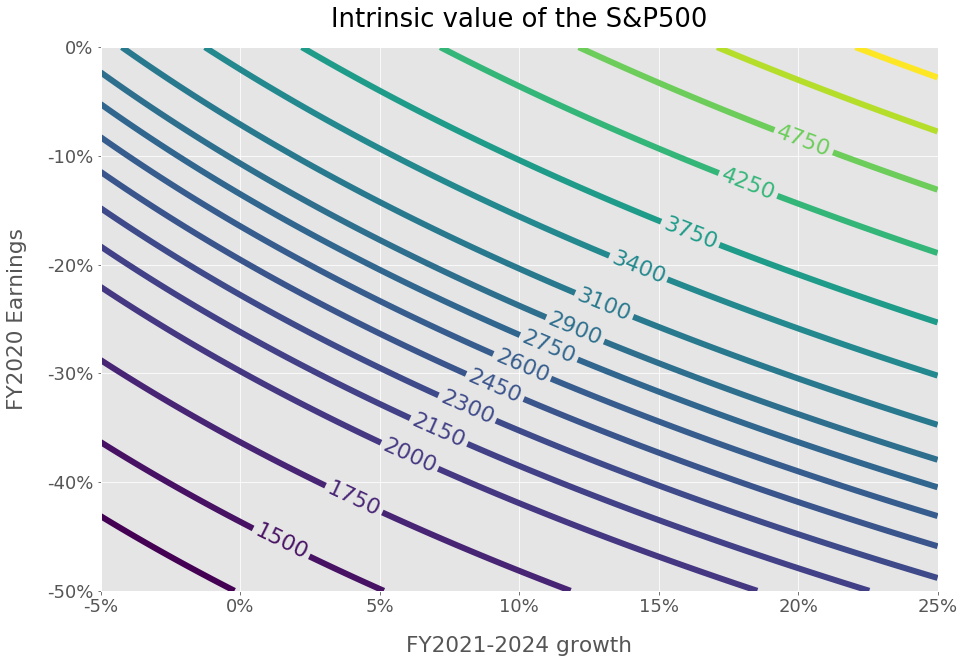

In [119]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(facecolor="w")
# levels = list(range(1500, 2301, 250)) + list(range(2350, 2551, 50)) + list(range(2600, 4501, 500))
levels = [1300, 1500, 1750] + list(range(2000, 3000, 150)) + [3100, 3400] + list(range(3750, 6000, 500))
CS = ax.contour(X, Y, Z, levels=levels, linewidths=6)

clabel_pos = []
for x in [0.01, 0.2, 0.04, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.16, 0.18]:
    clabel_pos.append((x, 2*x -0.5))

plt.clabel(CS,fmt="%1.0f", fontsize=22, manual=clabel_pos)
ax.set_xlabel("FY2021-2024 growth", labelpad=20)
ax.set_ylabel("FY2020 Earnings", labelpad=20)
ax.set_yticklabels([f"{100*y:.0f}%" for y in ax.get_yticks()])
ax.set_xticklabels([f"{100*x:.0f}%" for x in ax.get_xticks()])
ax.set_title("Intrinsic value of the S&P500", pad=20)

plt.show()

## Earnings recoupment

This is a more natural way to think of things, rather than FY21-24 growth.

In [182]:
def recoup_to_growth(frac, drop,
                    old_20_growth = 0.0552,
                    old_subs_growth = 0.0336,
                    ):
    return ((1+frac*(old_20_growth-drop)/(1+drop))*(1+old_subs_growth)**4)**0.25-1

def valuation_recoup(drop, frac, **kwargs):
    return valuation(drop, recoup_to_growth(frac, drop), **kwargs)

In [128]:
valuation_recoup(-0.1, 1)

3130.6700829544807

In [68]:
recoup_fracs = np.linspace(0, 1, n_res)
growths = []
for frac in recoup_fracs:
    growths.append(recoup_to_growth(frac, -0.3))

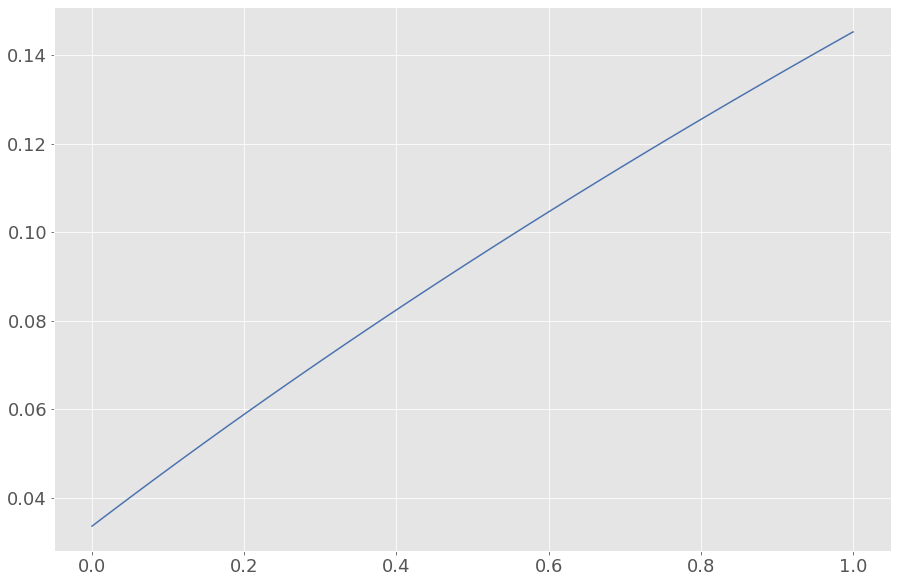

In [72]:
plt.plot(recoup_fracs, growths);

In [199]:
n_res = 100
recoup = np.linspace(0, 1, n_res)
drop = np.linspace(-0.5, 0, n_res)

X, Y = np.meshgrid(recoup, drop)
Z = np.zeros((n_res, n_res))
Z2 = np.zeros((n_res, n_res))
Z3 = np.zeros((n_res, n_res))

for i, x in enumerate(recoup):
    for j, y in enumerate(drop):
        Z[i, j] = valuation_recoup(y, x)
        Z2[i, j] = valuation_recoup(y, x, base_cash_return=0.7)
        Z3[i, j] = valuation_recoup(y, x, base_cash_return=0.92)

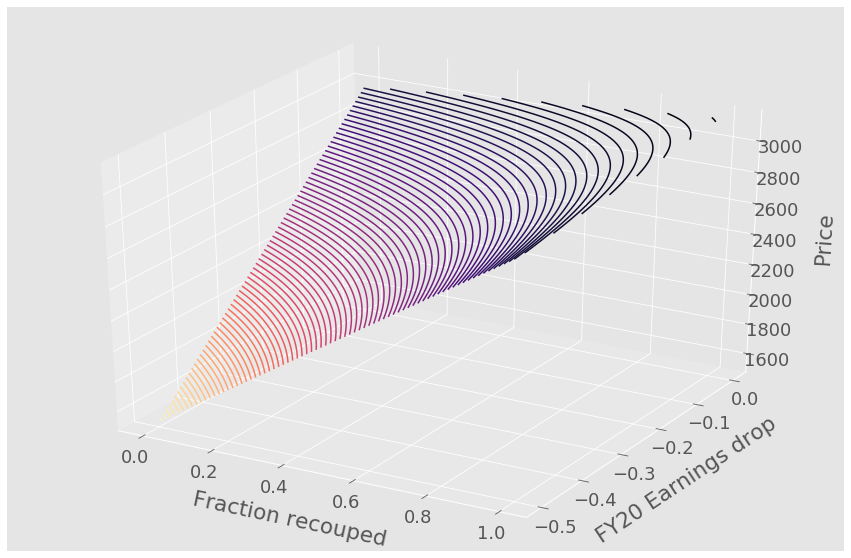

In [217]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 100, cmap="magma_r");
ax.set_xlabel("Fraction recouped", labelpad=20)
ax.set_ylabel("FY20 Earnings drop", labelpad=20)
ax.set_zlabel("Price", labelpad=20);
plt.savefig("spy_earnings_contour3d.png", dpi=500)

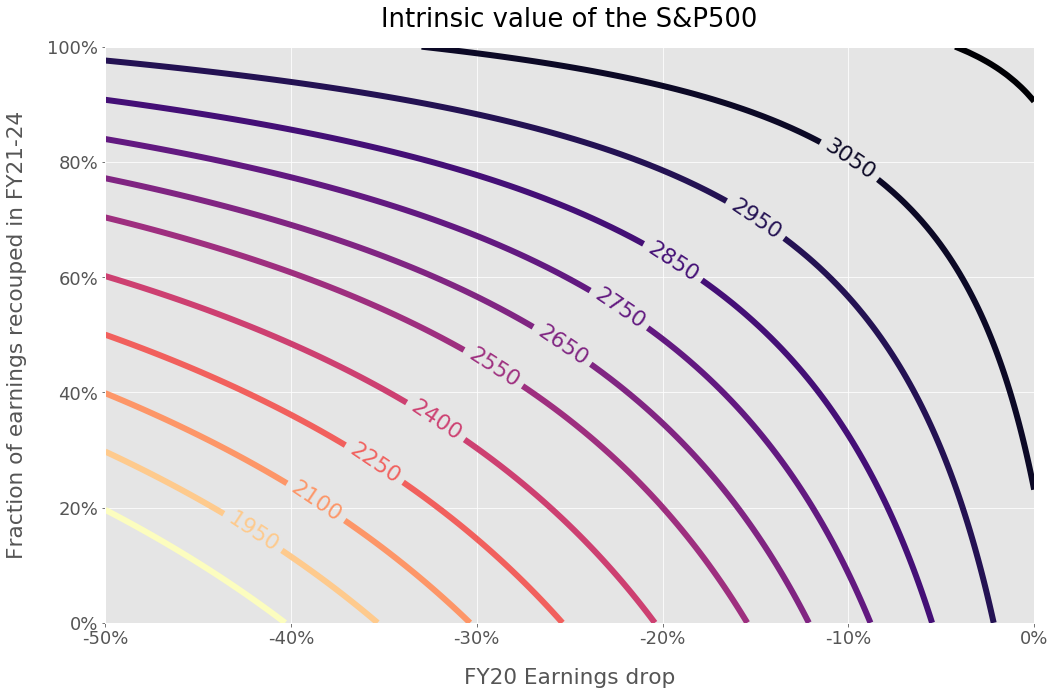

In [214]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(facecolor="w")
levels = [1800, 1950, 2100, 2250, 2400, 2550, 2650, 2750, 2850, 2950, 3050, 3150]
CS = ax.contour(Y, X, Z.T, levels=levels, linewidths=6, 
                cmap="magma_r"
               )
clabel_pos = []
for x in [-0.42, -0.38, -0.35, -0.32, -0.3, -0.25, -0.22, -0.2, -0.15, -0.1 ]:
    clabel_pos.append((x, 2*x +1))
plt.clabel(CS, fmt="%1.0f", fontsize=22, manual=clabel_pos)

ax.set_xlabel("FY20 Earnings drop", labelpad=20)
ax.set_ylabel("Fraction of earnings recouped in FY21-24", labelpad=20)
ax.set_yticklabels([f"{100*y:.0f}%" for y in ax.get_yticks()])
ax.set_xticklabels([f"{100*x:.0f}%" for x in ax.get_xticks()])
ax.set_title("Intrinsic value of the S&P500", pad=20)
plt.tight_layout()
plt.savefig("spy_earnings_fraction_contours.png", dpi=400)
plt.show()

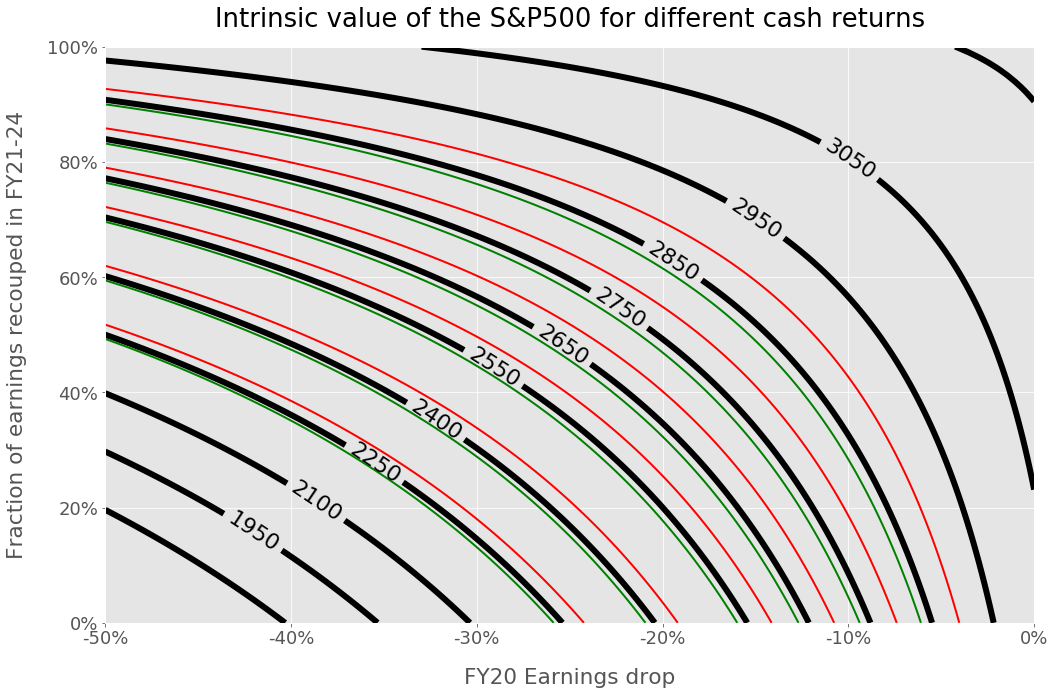

In [215]:
fig, ax = plt.subplots(facecolor="w")
levels = [1800, 1950, 2100, 2250, 2400, 2550, 2650, 2750, 2850, 2950, 3050, 3150]
CS = ax.contour(Y, X, Z.T, levels=levels, linewidths=6, 
                colors="k"
               )
clabel_pos = []
for x in [-0.42, -0.38, -0.35, -0.32, -0.3, -0.25, -0.22, -0.2, -0.15, -0.1 ]:
    clabel_pos.append((x, 2*x +1))
plt.clabel(CS, fmt="%1.0f", fontsize=22, manual=clabel_pos)

CS2 = ax.contour(Y,X, Z2.T, levels=levels[3:-3], linewidths=2, colors="red")
CS3 = ax.contour(Y,X, Z3.T, levels=levels[3:-3], linewidths=2, colors="green")


ax.set_xlabel("FY20 Earnings drop", labelpad=20)
ax.set_ylabel("Fraction of earnings recouped in FY21-24", labelpad=20)
ax.set_yticklabels([f"{100*y:.0f}%" for y in ax.get_yticks()])
ax.set_xticklabels([f"{100*x:.0f}%" for x in ax.get_xticks()])
ax.set_title("Intrinsic value of the S&P500 for different cash returns", pad=20)
plt.tight_layout()
# plt.savefig("spy_earnings_fraction_contours_different_returns.png", dpi=400)
plt.show()

In [163]:
clabel_pos

[-0.45, -0.42, -0.38, -0.35, -0.32, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05]